# Obligatory importing of libraries

In [1]:
import numpy as np
import math
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

# Define global parameters
### User definable parameters

In [2]:
############################
# Define global parameters #
############################

# Time-series parameters
N    = 1000    # Number of data points
dt   = 0.01    # Time resolution (days)

# Signal sinusoidal component parameters
Amp = 1.0   # variation amplitude (arbitraryunits)
frq = 10.0  # base frequncy (cycles / day)
phs = 0     # base phase (rads)

# Switches
addtuk   = 1     # Add Tukey filter?
skipgap  = 0     # Remove zero value data (i.e. skip the zeroed data gap)?
normLS   = 1     # Normalize Lonb-Scargle amplitudes?
addnoise = 0     # Add noise?
outfiles = 0     # Save plots to PDF files?

# Tukey Filter parameters
tuksz = 31  # Elemental size of filter

# Noise parameters
nmean = 0    # Set noise mean
nstd  = 1    # Set noise standard deviation

# Extra parameters
maxrange = 100  # Maximum percentage size of centralized data gap = 99%
osmp     = 1    # Lomb-Scargle oversampling factor
pltgap   = 50   # Choose data gap sample to plot

# Functions

In [3]:
#############
# Functions #
#############

### Initialise the signal

In [4]:
def initSignal(time, Amp, frq, phs, addnoise):

    # Initialise empty array with same dimension as time array
    sig = np.zeros(N)

    # Add four sinusoidal components with integer multiples of frequency
    for i in np.arange(1,5):
        sig += Amp*np.sin(2*np.pi*i*frq*time+phs)

    # If switched on, add simple Gaussian noise to signal
    if addnoise == 1:
        noise = np.random.normal(nmean, nstd, size=N)  # Produce noise array

        sig += noise # Add noise to signal

    return sig

### Build window function

In [5]:
def buildWindow(window, pczero):

    global winth

    # Produce top-hat style filter to apply to signal

    midp   = (N-1.0)/2                      # Central index of window function
    nmzero = np.floor(0.5*(0.01*pczero)*N)  # Half-length of data gap

    llim   = int(midp-nmzero+1)   # Define left index limit of region to zero out
    rlim   = int(midp+nmzero)     # Define right index limit of region to zero out
    zrge   = range(llim,rlim)     # Indices of window function to zero out

    window[zrge] = 0.0    # Zero out central region of window function

    # Collect top-hat filter for plotting
    winth = np.array(list(window))
                          # Clone top hat version of window function
                          # before application of Tukey filter
                          # to inner edges for plotting and to get
                          # around copying the original reference

    # If switched on, apply Tukey filter to steps of internal gap
    if addtuk == 1:

        # Apply Tukey filtering to edges of internal gap
        window = applyTukey(window, llim, rlim)

    return window, winth

### Apply Tukey filter to window function

In [6]:
def applyTukey(window, llim, rlim):

    tuk   = signal.tukey(tuksz,1) # Produce filter array
    endp  = len(tuk)-1            # End element index
    ltap  = tuk[int(endp/2):endp] # Left taper
    rtap  = tuk[0:int(endp/2)]    # Right taper

    #############
    # Left side #
    #############

    lliml = llim-len(ltap) # Left window fn index of taper
    if lliml < 0:  # Is left edge of taper beyond edge of window fn?
        lliml = 0  # Set left edge of taper to left edge of window fn
        ltap  = ltap[len(ltap)-(llim-lliml):len(ltap)]
    ltrge = range(lliml,llim)
#    print('l',llim,len(ltap),ltrge,len(ltap[len(ltap)-(llim-lliml):len(ltap)]))
     # for debugging

    ##############
    # Right side #
    ##############

    rlimr = rlim+len(rtap)  # Right window fn index of taper

    if rlimr > N-1:  # Is right edge of taper beyond edge of window fn?
        rlimr = N-1  # Set right edge of taper to right edge of window fn
        rtap  = rtap[0:rlimr-rlim]

    rtrge = range(rlim,rlimr)
#    print('r',rlim,len(rtap),rtrge,len(rtap[0:rlimr-rlim]))
     # for debugging

    # Apply Tukey-filter tapers to inside steps of window function
    window[ltrge] = ltap
    window[rtrge] = rtap

    return window

### Remove zeroed data (i.e. create data gap)

In [7]:
def gapSkip(skipgap, x, y):  # Remove data in x based on zeros in y

    if skipgap == 1:
        nongapvals = np.where(y != 0.0)
        return x[nongapvals]
    else:
        return x

### Perform Fast Fourier Transform

In [8]:
def performFFT(modsig):

    C        = fft(modsig, 2048) / (len(modsig)/2.0)
    freq     = 10*np.linspace(-0.5, 0.5, len(C))
    response = np.abs(fftshift(C / abs(C).max()))

    return freq, response

### Perform Lomb-Scargle Algorithm

In [9]:
def performLS(time, modsig, osmp, normLS):

    df   = 1/(osmp*dt*N)          # Frequency spacing
    Nyfq = 0.5/dt                 # Effective Nyquist frequency
    Nmfq = Nyfq/df                # Number of frequency array elements
    frqs = np.arange(df,Nyfq,df)  # Frequency array
    angs = 2*math.pi*frqs         # Angular Frequency array

    # Produce periodogram power spectrum & correspoding amplitude spectrum
    if normLS == 1:
        pgram = signal.lombscargle(time, modsig, angs, normalize = True)
        amps  = np.sqrt(4*pgram)
    else:
        pgram = signal.lombscargle(time, modsig, angs)
        amps  = np.sqrt(4*pgram/(N))

    return frqs, amps

### Initialize 2-D arrays

In [10]:
def arrayInit(maxrange, modsig, response, amps):

    sigs    = np.empty(shape=(maxrange,len(modsig)),dtype='float')
    fftamps = np.empty(shape=(maxrange,len(response)),dtype='float')
    LSamps  = np.empty(shape=(maxrange,len(amps)),dtype='float')

    return sigs, fftamps,LSamps

# Main Function

In [11]:
#################
# Main Function #
#################

### Some set-up: window-function, time and signal arrays

In [12]:
# Array holding example of top-hat filter for plotting purposes
global winth

# Define time array (days)
timefull = dt*np.arange(N)

# Produce initial (ungapped) signal
sig = initSignal(timefull, Amp, frq, phs, addnoise)

print("")
print("Signal initialised")
print("")


Signal initialised



In [13]:
print("Applying window function.")
print("")
print("Looping through data gap percentages:")

# Loop over data gap percentage size
for pczero in range(maxrange):

    print("{0:02d} ".format(pczero), end="", flush=True)

    window = np.ones(N)   # (Re-)Initialize window function

    # Add gap to window function
    if pczero > 0.0:

        # Construct window function
        window, winth = buildWindow(window, pczero)

    # Modulate signal with window function
    modsigfull = np.multiply(window,sig)

    time = gapSkip(skipgap, timefull, modsigfull)
    modsig = gapSkip(skipgap, modsigfull, modsigfull)

    if pczero == pltgap:
        timeplt  = time   # Clone time array for plotting
        sigplt   = modsig # Clone signal array for plotting
        winplt   = gapSkip(skipgap, window, modsigfull) # Clone window function for plotting
        winthplt = gapSkip(skipgap, winth, modsigfull)  # Clone top-hat function for plotting

    # Calculate FFT (Unused in this Lomb-Scargle version)
    freq, response = performFFT(modsig)

    # Calculate LS Amplitude Spectrum
    frqs, amps = performLS(time, modsig, osmp, normLS)

    # On first loop: initialise signal array, FT response spectra
    # and LS amplitude spectra across data gap array
    if pczero == 0:
        sigs, fftamps, LSamps = arrayInit(maxrange, modsigfull, response, amps)

    # Place current modulated signal, FFT response function
    # and LS amplitude array into respective arrays
    sigs[pczero,:]    = modsigfull
    fftamps[pczero,:] = response
    LSamps[pczero,:]  = amps

Applying window function.

Looping through data gap percentages:
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### The 2-D arrays have been produced
### Now sample the LS amplitude peak at the frequency of the fundamental component of the signal

In [14]:
print("")
print("[DONE]")
# Peak amplitude of fundamental signal component over data gap range
maxampdec = LSamps[:,99]


[DONE]


# Plotting procedures

In [15]:
#########
# Plots #
#########

### Figure 1:
### - 1) Plot filtered signal (blue), window function (green-dashed), Tukey filtered window function (red) with respect to time for a data gap of 'pltgap'
### - 2) Plot Lomb-Scargle frequency-spectrum amplitudes of this signal
### - 3) As above, but zoomed in to smaple around left-hand peak

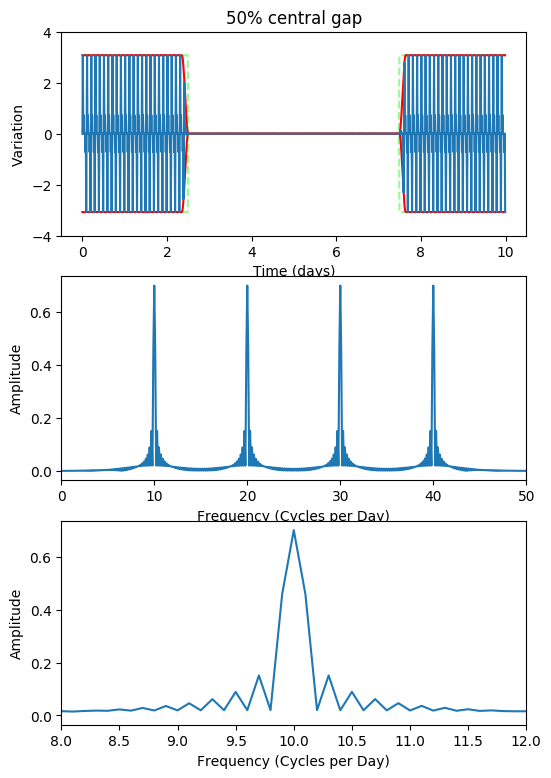

In [16]:
# Figure 1 - Plots for centralised gap of pltgap
fig1 = plt.figure(figsize = (6,9))

# Plot 1 - Signal + window function(s)
maxsig = max(sigplt)    # Signal amplitude (for scaling window fn)
ax   = fig1.add_subplot(3,1,1)
ax.set_ylim(-4,4)
ax.plot(timeplt,maxsig*winthplt,"--",c='palegreen')
ax.plot(timeplt,-maxsig*winthplt,"--",c='palegreen')
ax.plot(timeplt,maxsig*winplt,c='red')
ax.plot(timeplt,-maxsig*winplt,c='red')
ax.plot(timeplt,sigplt,c='C0')
ax.set_title(str(pltgap) + "% central gap")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Variation")
ax.grid(False)

# Plot 2 - LS Periodogram
ax = fig1.add_subplot(3,1,2)
ax.set_xlim(0, math.ceil(max(frqs))) # Define upper/lower limits of plot
ax.plot(frqs, LSamps[pltgap,:])
ax.set_xlabel("Frequency (Cycles per Day)")
ax.set_ylabel("Amplitude")
ax.grid(False)

# Plot 3 - LS Periodogram (zoomed)
#        - Spectral representation of window function
ax = fig1.add_subplot(3,1,3)
ax.set_xlim(8,12)   # Define upper/lower limits of plotw
ax.plot(frqs, LSamps[pltgap,:])
ax.set_xlabel("Frequency (Cycles per Day)")
ax.set_ylabel("Amplitude")
ax.grid(False)

# If switched on, save figure as PDF file
if outfiles == 1:
    fig1.savefig(\
    "Signal_FFT_LS-periodogram_for_4-component_signal_with_50pc_gap.pdf"\
            , bbox_inches='tight')

### Figure 2:
### Family of Lomb-Scargle periodograms plotted across percentage gap space

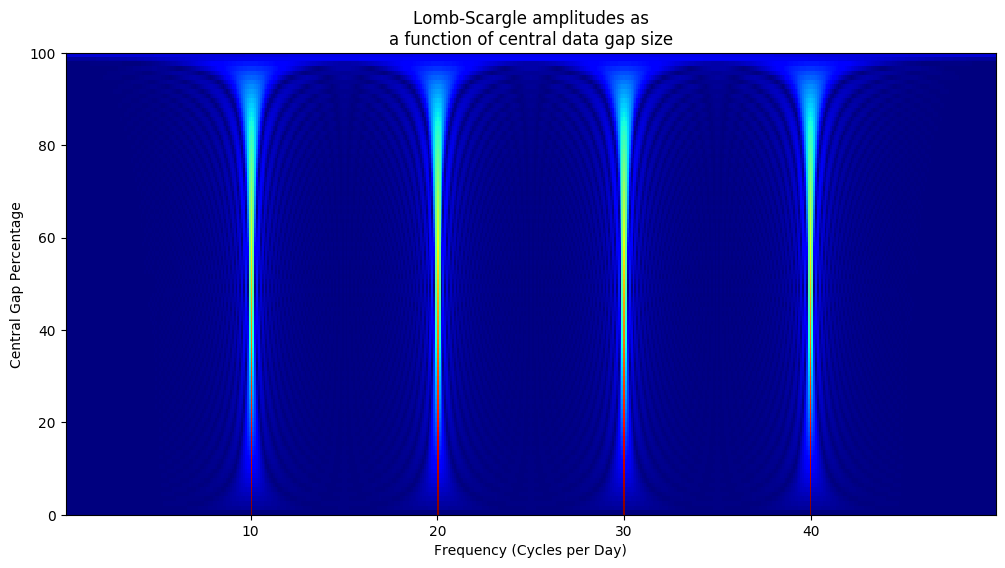

In [17]:
# Figure 2 - 2D showing LS periodogram for various gap sizes
fig2 = plt.figure(figsize=(12, 6))

ax  = fig2.add_subplot(111)

im = ax.imshow(LSamps, extent = (frqs.min(),frqs.max(),100,0)\
                     , aspect='auto', cmap='jet', interpolation='none')
ax.invert_yaxis()
ax.set_title("Lomb-Scargle amplitudes as\na function of central data gap size")
ax.set_xlabel('Frequency (Cycles per Day)')
ax.set_ylabel('Central Gap Percentage')

cax = fig2.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)

# If switched on, save figure as PDF file
if outfiles == 1:
    fig2.savefig("2D_LS_periodogram_with_increasing_gap.pdf"\
            , bbox_inches='tight')

### Figure 3:
### Variation of first peak's amplitude with increasing gap size

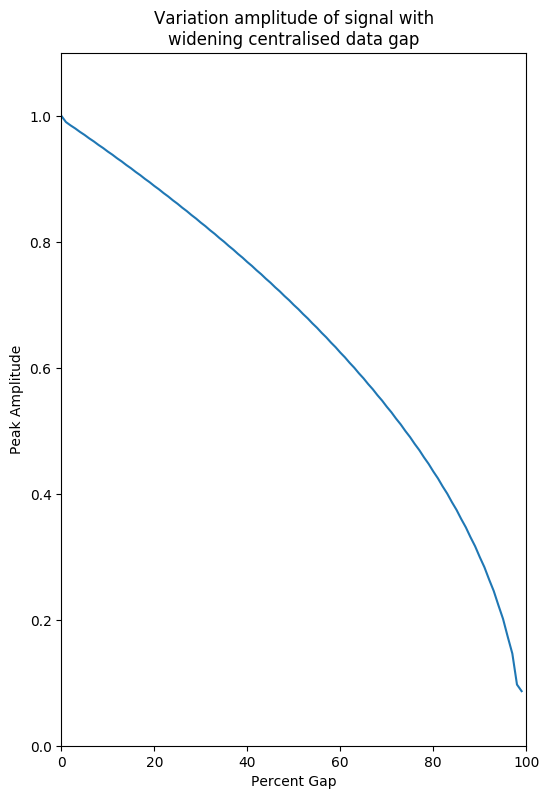

In [18]:
# Figure 3 - Variation of a single peak's amplitude with increasing gap size
fig3=plt.figure(figsize = (6,9))

ax = fig3.add_subplot(111)
ax.set_xlim(0,100)
ax.set_ylim(0,1.1)
ax.plot(maxampdec)
ax.set_title("Variation amplitude of signal with\nwidening centralised data gap")
ax.set_ylabel("Peak Amplitude")
ax.set_xlabel("Percent Gap")
ax.grid(False)

# If switched on, save figure as PDF file
if outfiles == 1:
    fig3.savefig("amplitude_decrease_with_increasing_gap.pdf"\
            , bbox_inches='tight')

# Show the plots, quit program

In [18]:
plt.show()  
quit()
